In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F
from models import *

import os
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'
dataset_path = '/narcissus/dataset/'

In [ ]:
import os
import torchvision
import torchvision.transforms as transforms

dataset_path = os.path.expanduser("~/datasets/")
cifar10_path = os.path.join(dataset_path, "cifar-10-batches-py")

if not os.path.exists(cifar10_path):
    print("Downloading CIFAR-10...")
    torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)
else:
    print("CIFAR-10 already downloaded.")


In [ ]:
import os
import urllib.request
import zipfile

tiny_imagenet_dir = os.path.join(dataset_path, "tiny-imagenet-200")

if not os.path.exists(tiny_imagenet_dir):
    print("Downloading Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(dataset_path, "tiny-imagenet-200.zip")
    
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting Tiny ImageNet...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(zip_path)
    print("Done.")
else:
    print("Tiny ImageNet already downloaded.")


In [ ]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
# dataset_path = '/home/minzhou/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [ ]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [ ]:
#Outter train dataset
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [ ]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [ ]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [ ]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [ ]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [ ]:
save_path = './checkpoint/surrogate_pretrain_' + str(surrogate_epochs) +'.pth'

if os.path.exists(save_path):
    print(f"Loading pre-trained surrogate model from {save_path}")
    surrogate_model.load_state_dict(torch.load(save_path))
else:
    print('Training the surrogate model')
    for epoch in range(0, surrogate_epochs):
        surrogate_model.train()
        loss_list = []
        for images, labels in surrogate_loader:
            images, labels = images.cuda(), labels.cuda()
            surrogate_opt.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_list.append(float(loss.data))
            surrogate_opt.step()
        surrogate_scheduler.step()
        ave_loss = np.average(np.array(loss_list))
        print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
    
    torch.save(surrogate_model.state_dict(), save_path)


# Poison warm up

In [ ]:
#cell 13
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [ ]:
#cell 14
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

# Trigger generating

In [ ]:
#cell 15
from tqdm.notebook import tqdm

#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [ ]:
#cell 16
#Save the trigger
import time
save_name = './checkpoint/best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [16]:
#cell 17
#Using this block if you only want to test the attack result.
import imageio
import cv2 as cv
best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load('./checkpoint/resnet18_trigger.npy')
best_noise = torch.from_numpy(noise_npy).cuda()

In [17]:
#cell 18
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [18]:
# cell 19
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [19]:
# cell 20
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [20]:
#cell 21
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)
poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

# Poison training data with randomized triggers
# random_poison_idx = random.sample(train_target_list, poison_amount)
# poison_train_target = poison_image_randomized(poi_ori_train, random_poison_idx, best_noise.cpu(), transform_after_train)
# print('Training dataset size is:', len(poison_train_target), " Poison numbers is:", len(random_poison_idx))
# clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)


Traing dataset size is: 50000  Poison numbers is: 25


In [21]:
#cell 22
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [22]:
#cell 23
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [23]:
#cell 24
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [27]:
#cell 25
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [30]:
from tqdm import tqdm

#cell 26
for epoch in tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

Acc 31.93 Loss: 1.93: 100%|██████████| 334/334 [01:40<00:00,  3.31it/s]

Train_loss: tensor(1.6868, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 3.92
Test_loss: tensor(3.0216, device='cuda:0')

Test clean Accuracy 43.11
Test_loss: tensor(1.5978, device='cuda:0')


  0%|          | 1/200 [01:51<6:11:06, 111.89s/it]


Target test clean Accuracy 12.00
Test_loss: tensor(1.9165, device='cuda:0')


Acc 46.47 Loss: 1.45: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(1.1755, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.92
Test_loss: tensor(3.9173, device='cuda:0')

Test clean Accuracy 52.31
Test_loss: tensor(1.3606, device='cuda:0')


  1%|          | 2/200 [03:28<5:40:31, 103.19s/it]


Target test clean Accuracy 41.20
Test_loss: tensor(1.7656, device='cuda:0')


Acc 57.28 Loss: 1.18: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(1.3351, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 1.40
Test_loss: tensor(3.3626, device='cuda:0')

Test clean Accuracy 56.92
Test_loss: tensor(1.2477, device='cuda:0')


  2%|▏         | 3/200 [05:06<5:29:46, 100.44s/it]


Target test clean Accuracy 43.20
Test_loss: tensor(1.5316, device='cuda:0')


Acc 64.58 Loss: 0.99: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.8784, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.57
Test_loss: tensor(3.1146, device='cuda:0')

Test clean Accuracy 63.25
Test_loss: tensor(1.0656, device='cuda:0')


  2%|▏         | 4/200 [06:43<5:23:39, 99.08s/it] 


Target test clean Accuracy 48.30
Test_loss: tensor(1.2370, device='cuda:0')


Acc 69.46 Loss: 0.87: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.8618, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 15.18
Test_loss: tensor(1.6578, device='cuda:0')

Test clean Accuracy 67.70
Test_loss: tensor(0.9107, device='cuda:0')


  2%|▎         | 5/200 [08:19<5:19:21, 98.26s/it]


Target test clean Accuracy 56.10
Test_loss: tensor(1.1742, device='cuda:0')


Acc 73.67 Loss: 0.75: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.6551, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 20.96
Test_loss: tensor(1.6346, device='cuda:0')

Test clean Accuracy 75.30
Test_loss: tensor(0.7200, device='cuda:0')


  3%|▎         | 6/200 [09:57<5:16:24, 97.86s/it]


Target test clean Accuracy 66.30
Test_loss: tensor(0.9889, device='cuda:0')


Acc 77.38 Loss: 0.65: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.6813, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 11.38
Test_loss: tensor(1.9448, device='cuda:0')

Test clean Accuracy 74.13
Test_loss: tensor(0.8154, device='cuda:0')


  4%|▎         | 7/200 [11:34<5:13:54, 97.59s/it]


Target test clean Accuracy 67.00
Test_loss: tensor(0.8961, device='cuda:0')


Acc 79.51 Loss: 0.59: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.5211, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 18.12
Test_loss: tensor(1.9179, device='cuda:0')

Test clean Accuracy 75.07
Test_loss: tensor(0.7712, device='cuda:0')


  4%|▍         | 8/200 [13:11<5:11:51, 97.45s/it]


Target test clean Accuracy 65.90
Test_loss: tensor(0.9803, device='cuda:0')


Acc 81.12 Loss: 0.55: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.8491, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.20
Test_loss: tensor(1.0276, device='cuda:0')

Test clean Accuracy 80.12
Test_loss: tensor(0.4497, device='cuda:0')


  4%|▍         | 9/200 [14:48<5:10:00, 97.38s/it]


Target test clean Accuracy 71.50
Test_loss: tensor(0.8134, device='cuda:0')


Acc 82.41 Loss: 0.51: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.3897, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 27.16
Test_loss: tensor(1.7599, device='cuda:0')

Test clean Accuracy 76.88
Test_loss: tensor(0.6969, device='cuda:0')


  5%|▌         | 10/200 [16:25<5:08:08, 97.31s/it]


Target test clean Accuracy 68.70
Test_loss: tensor(1.0991, device='cuda:0')


Acc 83.30 Loss: 0.49: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.5957, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 2.51
Test_loss: tensor(3.7602, device='cuda:0')

Test clean Accuracy 77.50
Test_loss: tensor(0.6681, device='cuda:0')


  6%|▌         | 11/200 [18:02<5:06:27, 97.29s/it]


Target test clean Accuracy 62.90
Test_loss: tensor(1.1431, device='cuda:0')


Acc 83.88 Loss: 0.47: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.4493, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 40.63
Test_loss: tensor(1.5685, device='cuda:0')

Test clean Accuracy 74.25
Test_loss: tensor(0.7016, device='cuda:0')


  6%|▌         | 12/200 [19:40<5:04:45, 97.26s/it]


Target test clean Accuracy 66.30
Test_loss: tensor(1.1903, device='cuda:0')


Acc 84.33 Loss: 0.45: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.3861, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 33.34
Test_loss: tensor(1.7168, device='cuda:0')

Test clean Accuracy 83.17
Test_loss: tensor(0.4513, device='cuda:0')


  6%|▋         | 13/200 [21:17<5:02:58, 97.21s/it]


Target test clean Accuracy 60.10
Test_loss: tensor(1.0000, device='cuda:0')


Acc 85.10 Loss: 0.44: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.2453, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 40.14
Test_loss: tensor(1.4557, device='cuda:0')

Test clean Accuracy 81.47
Test_loss: tensor(0.5771, device='cuda:0')


  7%|▋         | 14/200 [22:54<5:01:12, 97.17s/it]


Target test clean Accuracy 73.30
Test_loss: tensor(0.7777, device='cuda:0')


Acc 85.39 Loss: 0.42: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.3531, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.51
Test_loss: tensor(3.7022, device='cuda:0')

Test clean Accuracy 78.05
Test_loss: tensor(0.5787, device='cuda:0')


  8%|▊         | 15/200 [24:31<4:59:27, 97.12s/it]


Target test clean Accuracy 61.50
Test_loss: tensor(1.0049, device='cuda:0')


Acc 85.80 Loss: 0.41: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.4412, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 17.66
Test_loss: tensor(3.0161, device='cuda:0')

Test clean Accuracy 80.43
Test_loss: tensor(0.6320, device='cuda:0')


  8%|▊         | 16/200 [26:08<4:57:43, 97.08s/it]


Target test clean Accuracy 82.60
Test_loss: tensor(0.5662, device='cuda:0')


Acc 86.20 Loss: 0.40: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.3050, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 61.41
Test_loss: tensor(0.9914, device='cuda:0')

Test clean Accuracy 82.46
Test_loss: tensor(0.5880, device='cuda:0')


  8%|▊         | 17/200 [27:45<4:56:03, 97.07s/it]


Target test clean Accuracy 83.20
Test_loss: tensor(0.5039, device='cuda:0')


Acc 86.56 Loss: 0.39: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.7064, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 53.17
Test_loss: tensor(1.2626, device='cuda:0')

Test clean Accuracy 84.24
Test_loss: tensor(0.4446, device='cuda:0')


  9%|▉         | 18/200 [29:22<4:54:25, 97.06s/it]


Target test clean Accuracy 78.30
Test_loss: tensor(0.6176, device='cuda:0')


Acc 86.40 Loss: 0.40: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.6105, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 45.62
Test_loss: tensor(1.1305, device='cuda:0')

Test clean Accuracy 84.44
Test_loss: tensor(0.5455, device='cuda:0')


 10%|▉         | 19/200 [30:59<4:52:44, 97.04s/it]


Target test clean Accuracy 84.90
Test_loss: tensor(0.3953, device='cuda:0')


Acc 86.89 Loss: 0.38: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4080, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 11.56
Test_loss: tensor(2.4979, device='cuda:0')

Test clean Accuracy 80.75
Test_loss: tensor(0.3925, device='cuda:0')


 10%|█         | 20/200 [32:35<4:50:29, 96.83s/it]


Target test clean Accuracy 90.60
Test_loss: tensor(0.3028, device='cuda:0')


Acc 87.20 Loss: 0.38: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.4437, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 34.16
Test_loss: tensor(1.5003, device='cuda:0')

Test clean Accuracy 79.05
Test_loss: tensor(0.5142, device='cuda:0')


 10%|█         | 21/200 [34:12<4:48:55, 96.85s/it]


Target test clean Accuracy 92.70
Test_loss: tensor(0.3057, device='cuda:0')


Acc 87.43 Loss: 0.37: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4900, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 68.92
Test_loss: tensor(0.8267, device='cuda:0')

Test clean Accuracy 82.83
Test_loss: tensor(0.5403, device='cuda:0')


 11%|█         | 22/200 [35:48<4:46:55, 96.71s/it]


Target test clean Accuracy 87.80
Test_loss: tensor(0.2892, device='cuda:0')


Acc 87.49 Loss: 0.36: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.4283, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 22.70
Test_loss: tensor(1.7873, device='cuda:0')

Test clean Accuracy 81.56
Test_loss: tensor(0.5226, device='cuda:0')


 12%|█▏        | 23/200 [37:25<4:45:29, 96.77s/it]


Target test clean Accuracy 61.20
Test_loss: tensor(1.2406, device='cuda:0')


Acc 87.71 Loss: 0.36: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.4103, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 27.73
Test_loss: tensor(2.1371, device='cuda:0')

Test clean Accuracy 82.21
Test_loss: tensor(0.4325, device='cuda:0')


 12%|█▏        | 24/200 [39:02<4:43:52, 96.78s/it]


Target test clean Accuracy 77.10
Test_loss: tensor(0.8370, device='cuda:0')


Acc 88.29 Loss: 0.34: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2350, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 83.19
Test_loss: tensor(0.3944, device='cuda:0')

Test clean Accuracy 82.99
Test_loss: tensor(0.4574, device='cuda:0')


 12%|█▎        | 25/200 [40:39<4:42:23, 96.82s/it]


Target test clean Accuracy 83.50
Test_loss: tensor(0.4021, device='cuda:0')


Acc 88.20 Loss: 0.35: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.5093, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.49
Test_loss: tensor(0.6645, device='cuda:0')

Test clean Accuracy 86.31
Test_loss: tensor(0.4336, device='cuda:0')


 13%|█▎        | 26/200 [42:16<4:40:53, 96.86s/it]


Target test clean Accuracy 79.60
Test_loss: tensor(0.7426, device='cuda:0')


Acc 88.60 Loss: 0.33: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.4715, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 38.43
Test_loss: tensor(1.9786, device='cuda:0')

Test clean Accuracy 85.40
Test_loss: tensor(0.4238, device='cuda:0')


 14%|█▎        | 27/200 [43:53<4:39:24, 96.90s/it]


Target test clean Accuracy 82.10
Test_loss: tensor(0.5076, device='cuda:0')


Acc 88.38 Loss: 0.34: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3408, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 30.71
Test_loss: tensor(1.6397, device='cuda:0')

Test clean Accuracy 84.58
Test_loss: tensor(0.4516, device='cuda:0')


 14%|█▍        | 28/200 [45:30<4:37:46, 96.90s/it]


Target test clean Accuracy 72.60
Test_loss: tensor(0.8105, device='cuda:0')


Acc 88.54 Loss: 0.33: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.5829, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.24
Test_loss: tensor(3.7992, device='cuda:0')

Test clean Accuracy 79.73
Test_loss: tensor(0.5280, device='cuda:0')


 14%|█▍        | 29/200 [47:07<4:36:10, 96.90s/it]


Target test clean Accuracy 69.80
Test_loss: tensor(0.9093, device='cuda:0')


Acc 88.83 Loss: 0.33: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.3426, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 13.39
Test_loss: tensor(2.2647, device='cuda:0')

Test clean Accuracy 82.80
Test_loss: tensor(0.5390, device='cuda:0')


 15%|█▌        | 30/200 [48:44<4:34:38, 96.93s/it]


Target test clean Accuracy 74.40
Test_loss: tensor(0.6107, device='cuda:0')


Acc 88.89 Loss: 0.32: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.5037, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 7.03
Test_loss: tensor(2.6854, device='cuda:0')

Test clean Accuracy 84.47
Test_loss: tensor(0.4531, device='cuda:0')


 16%|█▌        | 31/200 [50:21<4:32:59, 96.92s/it]


Target test clean Accuracy 72.60
Test_loss: tensor(0.7063, device='cuda:0')


Acc 89.02 Loss: 0.32: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2425, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 4.58
Test_loss: tensor(2.7161, device='cuda:0')

Test clean Accuracy 85.64
Test_loss: tensor(0.3569, device='cuda:0')


 16%|█▌        | 32/200 [51:58<4:31:18, 96.90s/it]


Target test clean Accuracy 85.60
Test_loss: tensor(0.3465, device='cuda:0')


Acc 89.11 Loss: 0.32: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3903, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 33.36
Test_loss: tensor(2.0293, device='cuda:0')

Test clean Accuracy 82.30
Test_loss: tensor(0.4644, device='cuda:0')


 16%|█▋        | 33/200 [53:34<4:29:39, 96.88s/it]


Target test clean Accuracy 89.00
Test_loss: tensor(0.3410, device='cuda:0')


Acc 89.20 Loss: 0.32: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.5224, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 46.78
Test_loss: tensor(1.4895, device='cuda:0')

Test clean Accuracy 85.36
Test_loss: tensor(0.3909, device='cuda:0')


 17%|█▋        | 34/200 [55:11<4:28:08, 96.92s/it]


Target test clean Accuracy 79.30
Test_loss: tensor(0.7338, device='cuda:0')


Acc 89.22 Loss: 0.32: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.3040, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.00
Test_loss: tensor(0.2509, device='cuda:0')

Test clean Accuracy 80.49
Test_loss: tensor(0.4860, device='cuda:0')


 18%|█▊        | 35/200 [56:48<4:26:33, 96.93s/it]


Target test clean Accuracy 88.40
Test_loss: tensor(0.2881, device='cuda:0')


Acc 89.28 Loss: 0.31: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.2404, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 30.19
Test_loss: tensor(1.8570, device='cuda:0')

Test clean Accuracy 84.04
Test_loss: tensor(0.4334, device='cuda:0')


 18%|█▊        | 36/200 [58:25<4:24:59, 96.95s/it]


Target test clean Accuracy 68.40
Test_loss: tensor(1.0208, device='cuda:0')


Acc 89.59 Loss: 0.30: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.2542, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 36.27
Test_loss: tensor(1.9589, device='cuda:0')

Test clean Accuracy 85.43
Test_loss: tensor(0.5081, device='cuda:0')


 18%|█▊        | 37/200 [1:00:02<4:23:24, 96.96s/it]


Target test clean Accuracy 85.40
Test_loss: tensor(0.2812, device='cuda:0')


Acc 89.61 Loss: 0.31: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.6591, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 17.27
Test_loss: tensor(2.6346, device='cuda:0')

Test clean Accuracy 85.96
Test_loss: tensor(0.5033, device='cuda:0')


 19%|█▉        | 38/200 [1:01:39<4:21:44, 96.94s/it]


Target test clean Accuracy 83.50
Test_loss: tensor(0.3640, device='cuda:0')


Acc 89.64 Loss: 0.30: 100%|██████████| 334/334 [01:27<00:00,  3.82it/s]

Train_loss: tensor(0.2181, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 31.11
Test_loss: tensor(1.6057, device='cuda:0')

Test clean Accuracy 85.16
Test_loss: tensor(0.2441, device='cuda:0')


 20%|█▉        | 39/200 [1:03:16<4:20:15, 96.99s/it]


Target test clean Accuracy 84.30
Test_loss: tensor(0.4065, device='cuda:0')


Acc 89.91 Loss: 0.30: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.4186, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 18.57
Test_loss: tensor(2.1906, device='cuda:0')

Test clean Accuracy 84.28
Test_loss: tensor(0.5447, device='cuda:0')


 20%|██        | 40/200 [1:04:53<4:18:42, 97.02s/it]


Target test clean Accuracy 82.90
Test_loss: tensor(0.5606, device='cuda:0')


Acc 89.71 Loss: 0.30: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.5146, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 30.50
Test_loss: tensor(2.9435, device='cuda:0')

Test clean Accuracy 85.29
Test_loss: tensor(0.4598, device='cuda:0')


 20%|██        | 41/200 [1:06:30<4:16:56, 96.96s/it]


Target test clean Accuracy 85.70
Test_loss: tensor(0.3302, device='cuda:0')


Acc 90.03 Loss: 0.29: 100%|██████████| 334/334 [01:27<00:00,  3.82it/s]

Train_loss: tensor(0.3383, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.17
Test_loss: tensor(0.5156, device='cuda:0')

Test clean Accuracy 83.64
Test_loss: tensor(0.4438, device='cuda:0')


 21%|██        | 42/200 [1:08:07<4:15:15, 96.94s/it]


Target test clean Accuracy 82.00
Test_loss: tensor(0.8464, device='cuda:0')


Acc 90.10 Loss: 0.29: 100%|██████████| 334/334 [01:27<00:00,  3.82it/s]

Train_loss: tensor(0.3896, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.64
Test_loss: tensor(0.3823, device='cuda:0')

Test clean Accuracy 87.34
Test_loss: tensor(0.3793, device='cuda:0')


 22%|██▏       | 43/200 [1:09:44<4:13:38, 96.94s/it]


Target test clean Accuracy 86.50
Test_loss: tensor(0.3719, device='cuda:0')


Acc 89.69 Loss: 0.30: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.3849, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 4.47
Test_loss: tensor(2.8241, device='cuda:0')

Test clean Accuracy 84.38
Test_loss: tensor(0.4459, device='cuda:0')


 22%|██▏       | 44/200 [1:11:21<4:12:00, 96.92s/it]


Target test clean Accuracy 76.50
Test_loss: tensor(0.7701, device='cuda:0')


Acc 90.19 Loss: 0.29: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.3088, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 13.59
Test_loss: tensor(2.6035, device='cuda:0')

Test clean Accuracy 85.84
Test_loss: tensor(0.4100, device='cuda:0')


 22%|██▎       | 45/200 [1:12:58<4:10:24, 96.93s/it]


Target test clean Accuracy 74.00
Test_loss: tensor(0.8391, device='cuda:0')


Acc 90.21 Loss: 0.28: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.1463, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.40
Test_loss: tensor(1.3937, device='cuda:0')

Test clean Accuracy 85.71
Test_loss: tensor(0.3214, device='cuda:0')


 23%|██▎       | 46/200 [1:14:35<4:08:41, 96.89s/it]


Target test clean Accuracy 70.30
Test_loss: tensor(0.9215, device='cuda:0')


Acc 90.56 Loss: 0.28: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.4161, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 5.30
Test_loss: tensor(3.2002, device='cuda:0')

Test clean Accuracy 83.34
Test_loss: tensor(0.5217, device='cuda:0')


 24%|██▎       | 47/200 [1:16:12<4:07:12, 96.95s/it]


Target test clean Accuracy 76.20
Test_loss: tensor(0.6712, device='cuda:0')


Acc 90.65 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1617, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 54.41
Test_loss: tensor(1.3063, device='cuda:0')

Test clean Accuracy 86.72
Test_loss: tensor(0.3636, device='cuda:0')


 24%|██▍       | 48/200 [1:17:49<4:05:33, 96.93s/it]


Target test clean Accuracy 70.40
Test_loss: tensor(1.0174, device='cuda:0')


Acc 90.49 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2413, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 10.19
Test_loss: tensor(2.6842, device='cuda:0')

Test clean Accuracy 81.85
Test_loss: tensor(0.5292, device='cuda:0')


 24%|██▍       | 49/200 [1:19:25<4:03:51, 96.90s/it]


Target test clean Accuracy 66.60
Test_loss: tensor(1.1843, device='cuda:0')


Acc 90.65 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2477, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 12.61
Test_loss: tensor(2.9272, device='cuda:0')

Test clean Accuracy 82.94
Test_loss: tensor(0.5869, device='cuda:0')


 25%|██▌       | 50/200 [1:21:02<4:02:08, 96.86s/it]


Target test clean Accuracy 72.70
Test_loss: tensor(0.9133, device='cuda:0')


Acc 90.75 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2061, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 5.84
Test_loss: tensor(4.1660, device='cuda:0')

Test clean Accuracy 87.41
Test_loss: tensor(0.3061, device='cuda:0')


 26%|██▌       | 51/200 [1:22:39<4:00:29, 96.84s/it]


Target test clean Accuracy 80.80
Test_loss: tensor(0.5492, device='cuda:0')


Acc 90.65 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.2190, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 9.42
Test_loss: tensor(3.1125, device='cuda:0')

Test clean Accuracy 85.59
Test_loss: tensor(0.4192, device='cuda:0')


 26%|██▌       | 52/200 [1:24:16<3:58:54, 96.86s/it]


Target test clean Accuracy 79.60
Test_loss: tensor(0.6008, device='cuda:0')


Acc 90.64 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3949, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 77.78
Test_loss: tensor(0.8835, device='cuda:0')

Test clean Accuracy 85.77
Test_loss: tensor(0.2778, device='cuda:0')


 26%|██▋       | 53/200 [1:25:53<3:57:19, 96.87s/it]


Target test clean Accuracy 86.90
Test_loss: tensor(0.3830, device='cuda:0')


Acc 90.68 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3326, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.93
Test_loss: tensor(1.2144, device='cuda:0')

Test clean Accuracy 84.70
Test_loss: tensor(0.5930, device='cuda:0')


 27%|██▋       | 54/200 [1:27:30<3:55:40, 96.85s/it]


Target test clean Accuracy 77.20
Test_loss: tensor(0.6950, device='cuda:0')


Acc 90.74 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3567, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 29.66
Test_loss: tensor(1.9862, device='cuda:0')

Test clean Accuracy 85.07
Test_loss: tensor(0.4481, device='cuda:0')


 28%|██▊       | 55/200 [1:29:06<3:54:00, 96.83s/it]


Target test clean Accuracy 84.60
Test_loss: tensor(0.3652, device='cuda:0')


Acc 90.86 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2138, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.62
Test_loss: tensor(0.5540, device='cuda:0')

Test clean Accuracy 84.74
Test_loss: tensor(0.3925, device='cuda:0')


 28%|██▊       | 56/200 [1:30:43<3:52:21, 96.82s/it]


Target test clean Accuracy 80.80
Test_loss: tensor(0.6330, device='cuda:0')


Acc 91.01 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.4220, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 20.89
Test_loss: tensor(2.3766, device='cuda:0')

Test clean Accuracy 83.03
Test_loss: tensor(0.4945, device='cuda:0')


 28%|██▊       | 57/200 [1:32:20<3:50:39, 96.78s/it]


Target test clean Accuracy 65.90
Test_loss: tensor(1.2027, device='cuda:0')


Acc 91.16 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3491, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.99
Test_loss: tensor(0.4649, device='cuda:0')

Test clean Accuracy 86.08
Test_loss: tensor(0.3744, device='cuda:0')


 29%|██▉       | 58/200 [1:33:57<3:49:00, 96.76s/it]


Target test clean Accuracy 88.90
Test_loss: tensor(0.4234, device='cuda:0')


Acc 91.13 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2882, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 55.84
Test_loss: tensor(1.3637, device='cuda:0')

Test clean Accuracy 84.58
Test_loss: tensor(0.5338, device='cuda:0')


 30%|██▉       | 59/200 [1:35:33<3:47:27, 96.79s/it]


Target test clean Accuracy 91.00
Test_loss: tensor(0.2037, device='cuda:0')


Acc 91.16 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2949, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 37.69
Test_loss: tensor(1.5482, device='cuda:0')

Test clean Accuracy 88.48
Test_loss: tensor(0.3451, device='cuda:0')


 30%|███       | 60/200 [1:37:10<3:45:49, 96.78s/it]


Target test clean Accuracy 85.10
Test_loss: tensor(0.5473, device='cuda:0')


Acc 91.36 Loss: 0.25: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.1962, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 7.31
Test_loss: tensor(3.1847, device='cuda:0')

Test clean Accuracy 86.94
Test_loss: tensor(0.4175, device='cuda:0')


 30%|███       | 61/200 [1:38:46<3:43:40, 96.55s/it]


Target test clean Accuracy 85.10
Test_loss: tensor(0.5985, device='cuda:0')


Acc 91.41 Loss: 0.25: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3293, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 74.46
Test_loss: tensor(0.9295, device='cuda:0')

Test clean Accuracy 88.22
Test_loss: tensor(0.2567, device='cuda:0')


 31%|███       | 62/200 [1:40:23<3:42:13, 96.62s/it]


Target test clean Accuracy 81.50
Test_loss: tensor(0.5750, device='cuda:0')


Acc 91.27 Loss: 0.25: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 34.76
Test_loss: tensor(1.7341, device='cuda:0')

Test clean Accuracy 88.43
Test_loss: tensor(0.4002, device='cuda:0')


 32%|███▏      | 63/200 [1:42:00<3:40:45, 96.68s/it]


Target test clean Accuracy 77.60
Test_loss: tensor(0.6166, device='cuda:0')


Acc 91.56 Loss: 0.25: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1862, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 52.92
Test_loss: tensor(1.1804, device='cuda:0')

Test clean Accuracy 88.32
Test_loss: tensor(0.2905, device='cuda:0')


 32%|███▏      | 64/200 [1:43:37<3:39:15, 96.73s/it]


Target test clean Accuracy 85.40
Test_loss: tensor(0.4894, device='cuda:0')


Acc 91.67 Loss: 0.24: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3382, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 66.52
Test_loss: tensor(0.9039, device='cuda:0')

Test clean Accuracy 87.69
Test_loss: tensor(0.3322, device='cuda:0')


 32%|███▎      | 65/200 [1:45:14<3:37:43, 96.77s/it]


Target test clean Accuracy 82.90
Test_loss: tensor(0.4996, device='cuda:0')


Acc 91.62 Loss: 0.25: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2251, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 18.52
Test_loss: tensor(2.1518, device='cuda:0')

Test clean Accuracy 87.16
Test_loss: tensor(0.4239, device='cuda:0')


 33%|███▎      | 66/200 [1:46:50<3:36:06, 96.76s/it]


Target test clean Accuracy 89.10
Test_loss: tensor(0.3469, device='cuda:0')


Acc 91.62 Loss: 0.24: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2104, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.78
Test_loss: tensor(0.6712, device='cuda:0')

Test clean Accuracy 86.68
Test_loss: tensor(0.4061, device='cuda:0')


 34%|███▎      | 67/200 [1:48:27<3:34:24, 96.73s/it]


Target test clean Accuracy 81.00
Test_loss: tensor(0.5475, device='cuda:0')


Acc 91.79 Loss: 0.24: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3277, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 20.58
Test_loss: tensor(1.6782, device='cuda:0')

Test clean Accuracy 86.94
Test_loss: tensor(0.2795, device='cuda:0')


 34%|███▍      | 68/200 [1:50:04<3:32:50, 96.75s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.2452, device='cuda:0')


Acc 92.16 Loss: 0.23: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3047, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 4.36
Test_loss: tensor(2.8151, device='cuda:0')

Test clean Accuracy 85.46
Test_loss: tensor(0.2859, device='cuda:0')


 34%|███▍      | 69/200 [1:51:41<3:31:15, 96.76s/it]


Target test clean Accuracy 76.70
Test_loss: tensor(0.6825, device='cuda:0')


Acc 91.84 Loss: 0.24: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1652, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 47.20
Test_loss: tensor(1.6935, device='cuda:0')

Test clean Accuracy 84.63
Test_loss: tensor(0.5289, device='cuda:0')


 35%|███▌      | 70/200 [1:53:17<3:29:38, 96.76s/it]


Target test clean Accuracy 73.90
Test_loss: tensor(0.8081, device='cuda:0')


Acc 92.16 Loss: 0.23: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2520, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 27.67
Test_loss: tensor(2.6154, device='cuda:0')

Test clean Accuracy 86.94
Test_loss: tensor(0.3690, device='cuda:0')


 36%|███▌      | 71/200 [1:54:54<3:27:59, 96.74s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.2234, device='cuda:0')


Acc 92.22 Loss: 0.23: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.4426, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.69
Test_loss: tensor(1.1891, device='cuda:0')

Test clean Accuracy 84.65
Test_loss: tensor(0.5637, device='cuda:0')


 36%|███▌      | 72/200 [1:56:31<3:26:20, 96.72s/it]


Target test clean Accuracy 75.90
Test_loss: tensor(0.6035, device='cuda:0')


Acc 92.11 Loss: 0.23: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1872, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.19
Test_loss: tensor(1.2394, device='cuda:0')

Test clean Accuracy 88.20
Test_loss: tensor(0.2993, device='cuda:0')


 36%|███▋      | 73/200 [1:58:07<3:24:41, 96.71s/it]


Target test clean Accuracy 90.40
Test_loss: tensor(0.1944, device='cuda:0')


Acc 92.17 Loss: 0.23: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1849, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 83.88
Test_loss: tensor(0.5665, device='cuda:0')

Test clean Accuracy 86.72
Test_loss: tensor(0.4764, device='cuda:0')


 37%|███▋      | 74/200 [1:59:44<3:23:08, 96.74s/it]


Target test clean Accuracy 85.00
Test_loss: tensor(0.5124, device='cuda:0')


Acc 92.17 Loss: 0.23: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3499, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 54.83
Test_loss: tensor(1.3488, device='cuda:0')

Test clean Accuracy 89.65
Test_loss: tensor(0.3361, device='cuda:0')


 38%|███▊      | 75/200 [2:01:21<3:21:31, 96.73s/it]


Target test clean Accuracy 90.70
Test_loss: tensor(0.1900, device='cuda:0')


Acc 92.52 Loss: 0.22: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2884, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 50.27
Test_loss: tensor(1.5221, device='cuda:0')

Test clean Accuracy 85.54
Test_loss: tensor(0.3964, device='cuda:0')


 38%|███▊      | 76/200 [2:02:58<3:19:57, 96.75s/it]


Target test clean Accuracy 88.20
Test_loss: tensor(0.3775, device='cuda:0')


Acc 92.49 Loss: 0.22: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2747, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 55.43
Test_loss: tensor(1.1710, device='cuda:0')

Test clean Accuracy 87.61
Test_loss: tensor(0.3019, device='cuda:0')


 38%|███▊      | 77/200 [2:04:34<3:18:22, 96.77s/it]


Target test clean Accuracy 82.00
Test_loss: tensor(0.5862, device='cuda:0')


Acc 92.55 Loss: 0.22: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1170, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 74.76
Test_loss: tensor(0.8323, device='cuda:0')

Test clean Accuracy 89.65
Test_loss: tensor(0.2322, device='cuda:0')


 39%|███▉      | 78/200 [2:06:11<3:16:46, 96.77s/it]


Target test clean Accuracy 83.80
Test_loss: tensor(0.4144, device='cuda:0')


Acc 92.74 Loss: 0.21: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.99
Test_loss: tensor(0.2055, device='cuda:0')

Test clean Accuracy 84.47
Test_loss: tensor(0.3874, device='cuda:0')


 40%|███▉      | 79/200 [2:07:48<3:15:09, 96.77s/it]


Target test clean Accuracy 77.40
Test_loss: tensor(0.8748, device='cuda:0')


Acc 92.78 Loss: 0.21: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1800, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 48.28
Test_loss: tensor(1.8068, device='cuda:0')

Test clean Accuracy 88.83
Test_loss: tensor(0.3647, device='cuda:0')


 40%|████      | 80/200 [2:09:25<3:13:29, 96.75s/it]


Target test clean Accuracy 87.40
Test_loss: tensor(0.3939, device='cuda:0')


Acc 92.64 Loss: 0.22: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.5509, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.30
Test_loss: tensor(0.6590, device='cuda:0')

Test clean Accuracy 88.91
Test_loss: tensor(0.4222, device='cuda:0')


 40%|████      | 81/200 [2:11:01<3:11:51, 96.74s/it]


Target test clean Accuracy 86.50
Test_loss: tensor(0.4227, device='cuda:0')


Acc 92.61 Loss: 0.21: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.3623, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 57.41
Test_loss: tensor(1.0201, device='cuda:0')

Test clean Accuracy 85.18
Test_loss: tensor(0.4369, device='cuda:0')


 41%|████      | 82/200 [2:12:38<3:10:16, 96.75s/it]


Target test clean Accuracy 75.80
Test_loss: tensor(0.9836, device='cuda:0')


Acc 92.76 Loss: 0.21: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1668, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.42
Test_loss: tensor(0.5029, device='cuda:0')

Test clean Accuracy 86.60
Test_loss: tensor(0.2931, device='cuda:0')


 42%|████▏     | 83/200 [2:14:15<3:08:39, 96.74s/it]


Target test clean Accuracy 85.20
Test_loss: tensor(0.5136, device='cuda:0')


Acc 93.15 Loss: 0.20: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2172, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 43.89
Test_loss: tensor(1.2572, device='cuda:0')

Test clean Accuracy 87.46
Test_loss: tensor(0.4181, device='cuda:0')


 42%|████▏     | 84/200 [2:15:52<3:07:00, 96.73s/it]


Target test clean Accuracy 84.60
Test_loss: tensor(0.5051, device='cuda:0')


Acc 93.16 Loss: 0.20: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.2581, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.32
Test_loss: tensor(0.2643, device='cuda:0')

Test clean Accuracy 86.75
Test_loss: tensor(0.3376, device='cuda:0')


 42%|████▎     | 85/200 [2:17:29<3:05:30, 96.79s/it]


Target test clean Accuracy 79.80
Test_loss: tensor(0.7879, device='cuda:0')


Acc 93.19 Loss: 0.20: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1774, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 63.98
Test_loss: tensor(0.9802, device='cuda:0')

Test clean Accuracy 87.09
Test_loss: tensor(0.3161, device='cuda:0')


 43%|████▎     | 86/200 [2:19:05<3:03:50, 96.76s/it]


Target test clean Accuracy 85.70
Test_loss: tensor(0.4962, device='cuda:0')


Acc 93.07 Loss: 0.20: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1645, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.16
Test_loss: tensor(0.2233, device='cuda:0')

Test clean Accuracy 87.61
Test_loss: tensor(0.3715, device='cuda:0')


 44%|████▎     | 87/200 [2:20:42<3:02:11, 96.74s/it]


Target test clean Accuracy 85.30
Test_loss: tensor(0.5527, device='cuda:0')


Acc 93.69 Loss: 0.19: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.4662, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 20.04
Test_loss: tensor(2.1503, device='cuda:0')

Test clean Accuracy 88.06
Test_loss: tensor(0.3181, device='cuda:0')


 44%|████▍     | 88/200 [2:22:19<3:00:33, 96.73s/it]


Target test clean Accuracy 86.40
Test_loss: tensor(0.2956, device='cuda:0')


Acc 93.29 Loss: 0.20: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2497, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 17.61
Test_loss: tensor(3.2119, device='cuda:0')

Test clean Accuracy 86.99
Test_loss: tensor(0.3054, device='cuda:0')


 44%|████▍     | 89/200 [2:23:55<2:58:57, 96.73s/it]


Target test clean Accuracy 65.30
Test_loss: tensor(0.9312, device='cuda:0')


Acc 93.34 Loss: 0.19: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2546, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 67.49
Test_loss: tensor(0.8206, device='cuda:0')

Test clean Accuracy 89.25
Test_loss: tensor(0.2789, device='cuda:0')


 45%|████▌     | 90/200 [2:25:32<2:57:18, 96.72s/it]


Target test clean Accuracy 82.00
Test_loss: tensor(0.5366, device='cuda:0')


Acc 93.58 Loss: 0.19: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2174, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 63.62
Test_loss: tensor(1.0588, device='cuda:0')

Test clean Accuracy 87.94
Test_loss: tensor(0.3504, device='cuda:0')


 46%|████▌     | 91/200 [2:27:09<2:55:42, 96.72s/it]


Target test clean Accuracy 82.50
Test_loss: tensor(0.8262, device='cuda:0')


Acc 93.72 Loss: 0.18: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.3007, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.00
Test_loss: tensor(0.5266, device='cuda:0')

Test clean Accuracy 88.42
Test_loss: tensor(0.3141, device='cuda:0')


 46%|████▌     | 92/200 [2:28:45<2:54:00, 96.67s/it]


Target test clean Accuracy 92.10
Test_loss: tensor(0.3335, device='cuda:0')


Acc 93.70 Loss: 0.18: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2208, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 67.21
Test_loss: tensor(1.2049, device='cuda:0')

Test clean Accuracy 87.46
Test_loss: tensor(0.3522, device='cuda:0')


 46%|████▋     | 93/200 [2:30:22<2:52:25, 96.69s/it]


Target test clean Accuracy 95.00
Test_loss: tensor(0.1692, device='cuda:0')


Acc 93.79 Loss: 0.18: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1233, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 54.49
Test_loss: tensor(0.9913, device='cuda:0')

Test clean Accuracy 89.47
Test_loss: tensor(0.3861, device='cuda:0')


 47%|████▋     | 94/200 [2:31:59<2:50:50, 96.71s/it]


Target test clean Accuracy 85.50
Test_loss: tensor(0.1573, device='cuda:0')


Acc 93.76 Loss: 0.18: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2283, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.41
Test_loss: tensor(0.7340, device='cuda:0')

Test clean Accuracy 86.78
Test_loss: tensor(0.5242, device='cuda:0')


 48%|████▊     | 95/200 [2:33:36<2:49:17, 96.74s/it]


Target test clean Accuracy 85.50
Test_loss: tensor(0.2606, device='cuda:0')


Acc 93.99 Loss: 0.18: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1682, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.89
Test_loss: tensor(0.6348, device='cuda:0')

Test clean Accuracy 88.14
Test_loss: tensor(0.3030, device='cuda:0')


 48%|████▊     | 96/200 [2:35:12<2:47:40, 96.73s/it]


Target test clean Accuracy 83.70
Test_loss: tensor(0.5994, device='cuda:0')


Acc 94.03 Loss: 0.17: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1642, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 44.02
Test_loss: tensor(1.6585, device='cuda:0')

Test clean Accuracy 88.70
Test_loss: tensor(0.3226, device='cuda:0')


 48%|████▊     | 97/200 [2:36:49<2:46:01, 96.72s/it]


Target test clean Accuracy 71.60
Test_loss: tensor(1.0913, device='cuda:0')


Acc 94.06 Loss: 0.17: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1335, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 58.91
Test_loss: tensor(1.2464, device='cuda:0')

Test clean Accuracy 88.54
Test_loss: tensor(0.3396, device='cuda:0')


 49%|████▉     | 98/200 [2:38:26<2:44:26, 96.73s/it]


Target test clean Accuracy 86.90
Test_loss: tensor(0.3901, device='cuda:0')


Acc 94.35 Loss: 0.17: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2627, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.12
Test_loss: tensor(1.0730, device='cuda:0')

Test clean Accuracy 90.17
Test_loss: tensor(0.2323, device='cuda:0')


 50%|████▉     | 99/200 [2:40:03<2:42:48, 96.72s/it]


Target test clean Accuracy 88.00
Test_loss: tensor(0.2388, device='cuda:0')


Acc 94.37 Loss: 0.16: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2428, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 66.82
Test_loss: tensor(0.9005, device='cuda:0')

Test clean Accuracy 88.66
Test_loss: tensor(0.2703, device='cuda:0')


 50%|█████     | 100/200 [2:41:39<2:41:13, 96.74s/it]


Target test clean Accuracy 84.80
Test_loss: tensor(0.3387, device='cuda:0')


Acc 94.29 Loss: 0.16: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0974, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.27
Test_loss: tensor(0.1252, device='cuda:0')

Test clean Accuracy 88.79
Test_loss: tensor(0.3136, device='cuda:0')


 50%|█████     | 101/200 [2:43:16<2:39:36, 96.74s/it]


Target test clean Accuracy 79.00
Test_loss: tensor(0.6499, device='cuda:0')


Acc 94.42 Loss: 0.16: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1672, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 30.94
Test_loss: tensor(1.8026, device='cuda:0')

Test clean Accuracy 89.76
Test_loss: tensor(0.3693, device='cuda:0')


 51%|█████     | 102/200 [2:44:53<2:37:55, 96.69s/it]


Target test clean Accuracy 83.70
Test_loss: tensor(0.7314, device='cuda:0')


Acc 94.52 Loss: 0.16: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1033, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 61.87
Test_loss: tensor(1.2757, device='cuda:0')

Test clean Accuracy 90.26
Test_loss: tensor(0.2345, device='cuda:0')


 52%|█████▏    | 103/200 [2:46:29<2:36:18, 96.68s/it]


Target test clean Accuracy 87.20
Test_loss: tensor(0.4648, device='cuda:0')


Acc 94.82 Loss: 0.15: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2570, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 47.74
Test_loss: tensor(1.1523, device='cuda:0')

Test clean Accuracy 88.82
Test_loss: tensor(0.3474, device='cuda:0')


 52%|█████▏    | 104/200 [2:48:06<2:34:42, 96.69s/it]


Target test clean Accuracy 85.70
Test_loss: tensor(0.5001, device='cuda:0')


Acc 94.66 Loss: 0.15: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1327, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.13
Test_loss: tensor(0.5043, device='cuda:0')

Test clean Accuracy 90.73
Test_loss: tensor(0.3650, device='cuda:0')


 52%|█████▎    | 105/200 [2:49:43<2:33:06, 96.70s/it]


Target test clean Accuracy 86.70
Test_loss: tensor(0.5679, device='cuda:0')


Acc 94.93 Loss: 0.15: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.17
Test_loss: tensor(0.3417, device='cuda:0')

Test clean Accuracy 90.37
Test_loss: tensor(0.2112, device='cuda:0')


 53%|█████▎    | 106/200 [2:51:20<2:31:34, 96.75s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.4322, device='cuda:0')


Acc 94.94 Loss: 0.15: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 83.41
Test_loss: tensor(0.4347, device='cuda:0')

Test clean Accuracy 89.95
Test_loss: tensor(0.3669, device='cuda:0')


 54%|█████▎    | 107/200 [2:52:56<2:29:57, 96.74s/it]


Target test clean Accuracy 89.80
Test_loss: tensor(0.2025, device='cuda:0')


Acc 95.01 Loss: 0.14: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1880, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.73
Test_loss: tensor(0.5888, device='cuda:0')

Test clean Accuracy 87.68
Test_loss: tensor(0.4393, device='cuda:0')


 54%|█████▍    | 108/200 [2:54:33<2:28:12, 96.66s/it]


Target test clean Accuracy 85.90
Test_loss: tensor(0.5065, device='cuda:0')


Acc 95.14 Loss: 0.14: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.2224, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 71.33
Test_loss: tensor(0.7525, device='cuda:0')

Test clean Accuracy 88.06
Test_loss: tensor(0.4200, device='cuda:0')


 55%|█████▍    | 109/200 [2:56:10<2:26:38, 96.69s/it]


Target test clean Accuracy 85.40
Test_loss: tensor(0.4921, device='cuda:0')


Acc 95.13 Loss: 0.14: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.1484, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 22.32
Test_loss: tensor(2.0739, device='cuda:0')

Test clean Accuracy 89.11
Test_loss: tensor(0.3423, device='cuda:0')


 55%|█████▌    | 110/200 [2:57:46<2:25:06, 96.74s/it]


Target test clean Accuracy 74.10
Test_loss: tensor(1.1144, device='cuda:0')


Acc 95.15 Loss: 0.14: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.0411, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.89
Test_loss: tensor(0.9063, device='cuda:0')

Test clean Accuracy 90.70
Test_loss: tensor(0.2017, device='cuda:0')


 56%|█████▌    | 111/200 [2:59:23<2:23:29, 96.74s/it]


Target test clean Accuracy 82.60
Test_loss: tensor(0.5567, device='cuda:0')


Acc 95.57 Loss: 0.13: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.0952, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 61.59
Test_loss: tensor(1.0558, device='cuda:0')

Test clean Accuracy 90.78
Test_loss: tensor(0.3538, device='cuda:0')


 56%|█████▌    | 112/200 [3:01:00<2:21:55, 96.77s/it]


Target test clean Accuracy 87.80
Test_loss: tensor(0.4762, device='cuda:0')


Acc 95.56 Loss: 0.13: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.2348, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.63
Test_loss: tensor(0.5963, device='cuda:0')

Test clean Accuracy 90.18
Test_loss: tensor(0.2797, device='cuda:0')


 56%|█████▋    | 113/200 [3:02:37<2:20:18, 96.76s/it]


Target test clean Accuracy 86.10
Test_loss: tensor(0.6671, device='cuda:0')


Acc 95.55 Loss: 0.13: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.1803, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.51
Test_loss: tensor(0.4238, device='cuda:0')

Test clean Accuracy 90.39
Test_loss: tensor(0.3765, device='cuda:0')


 57%|█████▋    | 114/200 [3:04:14<2:18:45, 96.81s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.2741, device='cuda:0')


Acc 95.69 Loss: 0.13: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.0765, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 69.44
Test_loss: tensor(1.1219, device='cuda:0')

Test clean Accuracy 90.38
Test_loss: tensor(0.4142, device='cuda:0')


 57%|█████▊    | 115/200 [3:05:50<2:17:02, 96.74s/it]


Target test clean Accuracy 87.10
Test_loss: tensor(0.8419, device='cuda:0')


Acc 95.74 Loss: 0.12: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.1565, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.84
Test_loss: tensor(0.3557, device='cuda:0')

Test clean Accuracy 91.13
Test_loss: tensor(0.1762, device='cuda:0')


 58%|█████▊    | 116/200 [3:07:27<2:15:27, 96.75s/it]


Target test clean Accuracy 86.00
Test_loss: tensor(0.7814, device='cuda:0')


Acc 95.76 Loss: 0.12: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.0676, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 69.86
Test_loss: tensor(0.9512, device='cuda:0')

Test clean Accuracy 90.24
Test_loss: tensor(0.2826, device='cuda:0')


 58%|█████▊    | 117/200 [3:09:04<2:13:51, 96.76s/it]


Target test clean Accuracy 85.20
Test_loss: tensor(0.7110, device='cuda:0')


Acc 95.81 Loss: 0.12: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.2154, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.74
Test_loss: tensor(1.1268, device='cuda:0')

Test clean Accuracy 90.20
Test_loss: tensor(0.2324, device='cuda:0')


 59%|█████▉    | 118/200 [3:10:41<2:12:15, 96.77s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.4269, device='cuda:0')


Acc 95.85 Loss: 0.12: 100%|██████████| 334/334 [01:26<00:00,  3.84it/s]

Train_loss: tensor(0.1547, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.97
Test_loss: tensor(1.1176, device='cuda:0')

Test clean Accuracy 89.31
Test_loss: tensor(0.3288, device='cuda:0')


 60%|█████▉    | 119/200 [3:12:17<2:10:35, 96.73s/it]


Target test clean Accuracy 83.00
Test_loss: tensor(0.7421, device='cuda:0')


Acc 96.10 Loss: 0.11: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.07
Test_loss: tensor(0.0900, device='cuda:0')

Test clean Accuracy 91.62
Test_loss: tensor(0.1546, device='cuda:0')


 60%|██████    | 120/200 [3:13:54<2:08:57, 96.72s/it]


Target test clean Accuracy 88.20
Test_loss: tensor(0.2744, device='cuda:0')


Acc 96.20 Loss: 0.11: 100%|██████████| 334/334 [01:27<00:00,  3.84it/s]

Train_loss: tensor(0.0827, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.73
Test_loss: tensor(0.2310, device='cuda:0')

Test clean Accuracy 87.27
Test_loss: tensor(0.2856, device='cuda:0')


 60%|██████    | 121/200 [3:15:31<2:07:19, 96.70s/it]


Target test clean Accuracy 90.10
Test_loss: tensor(0.4198, device='cuda:0')


Acc 96.41 Loss: 0.11: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0450, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 79.01
Test_loss: tensor(0.6481, device='cuda:0')

Test clean Accuracy 91.12
Test_loss: tensor(0.1919, device='cuda:0')


 61%|██████    | 122/200 [3:17:07<2:05:42, 96.70s/it]


Target test clean Accuracy 91.40
Test_loss: tensor(0.2001, device='cuda:0')


Acc 96.59 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.1054, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.31
Test_loss: tensor(0.5150, device='cuda:0')

Test clean Accuracy 89.76
Test_loss: tensor(0.2959, device='cuda:0')


 62%|██████▏   | 123/200 [3:18:44<2:04:06, 96.70s/it]


Target test clean Accuracy 83.90
Test_loss: tensor(0.3022, device='cuda:0')


Acc 96.47 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1250, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.14
Test_loss: tensor(0.2059, device='cuda:0')

Test clean Accuracy 90.50
Test_loss: tensor(0.2534, device='cuda:0')


 62%|██████▏   | 124/200 [3:20:21<2:02:27, 96.68s/it]


Target test clean Accuracy 93.80
Test_loss: tensor(0.1984, device='cuda:0')


Acc 96.71 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.2502, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 85.43
Test_loss: tensor(0.3995, device='cuda:0')

Test clean Accuracy 91.36
Test_loss: tensor(0.2143, device='cuda:0')


 62%|██████▎   | 125/200 [3:21:57<2:00:50, 96.67s/it]


Target test clean Accuracy 88.90
Test_loss: tensor(0.2546, device='cuda:0')


Acc 96.35 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1684, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 39.51
Test_loss: tensor(1.8046, device='cuda:0')

Test clean Accuracy 91.07
Test_loss: tensor(0.2733, device='cuda:0')


 63%|██████▎   | 126/200 [3:23:34<1:59:12, 96.66s/it]


Target test clean Accuracy 85.90
Test_loss: tensor(0.3396, device='cuda:0')


Acc 96.73 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.2720, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.32
Test_loss: tensor(0.4829, device='cuda:0')

Test clean Accuracy 91.76
Test_loss: tensor(0.1669, device='cuda:0')


 64%|██████▎   | 127/200 [3:25:10<1:57:33, 96.62s/it]


Target test clean Accuracy 88.80
Test_loss: tensor(0.3622, device='cuda:0')


Acc 96.79 Loss: 0.09: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.2330, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.53
Test_loss: tensor(0.0636, device='cuda:0')

Test clean Accuracy 91.96
Test_loss: tensor(0.1941, device='cuda:0')


 64%|██████▍   | 128/200 [3:26:47<1:55:55, 96.61s/it]


Target test clean Accuracy 90.20
Test_loss: tensor(0.2863, device='cuda:0')


Acc 96.94 Loss: 0.09: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1537, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.36
Test_loss: tensor(0.2046, device='cuda:0')

Test clean Accuracy 90.70
Test_loss: tensor(0.2637, device='cuda:0')


 64%|██████▍   | 129/200 [3:28:24<1:54:18, 96.60s/it]


Target test clean Accuracy 93.80
Test_loss: tensor(0.1781, device='cuda:0')


Acc 96.94 Loss: 0.09: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0704, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 64.06
Test_loss: tensor(1.1062, device='cuda:0')

Test clean Accuracy 91.08
Test_loss: tensor(0.2734, device='cuda:0')


 65%|██████▌   | 130/200 [3:30:00<1:52:41, 96.59s/it]


Target test clean Accuracy 81.40
Test_loss: tensor(0.4010, device='cuda:0')


Acc 97.07 Loss: 0.09: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0677, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.14
Test_loss: tensor(0.1237, device='cuda:0')

Test clean Accuracy 91.85
Test_loss: tensor(0.1274, device='cuda:0')


 66%|██████▌   | 131/200 [3:31:37<1:51:04, 96.59s/it]


Target test clean Accuracy 86.30
Test_loss: tensor(0.5310, device='cuda:0')


Acc 97.45 Loss: 0.08: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1426, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.99
Test_loss: tensor(0.0965, device='cuda:0')

Test clean Accuracy 90.89
Test_loss: tensor(0.3115, device='cuda:0')


 66%|██████▌   | 132/200 [3:33:13<1:49:28, 96.60s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.1026, device='cuda:0')


Acc 97.40 Loss: 0.08: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0841, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.59
Test_loss: tensor(0.2984, device='cuda:0')

Test clean Accuracy 91.97
Test_loss: tensor(0.2183, device='cuda:0')


 66%|██████▋   | 133/200 [3:34:50<1:47:49, 96.57s/it]


Target test clean Accuracy 90.30
Test_loss: tensor(0.3132, device='cuda:0')


Acc 97.37 Loss: 0.08: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0420, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.39
Test_loss: tensor(0.3436, device='cuda:0')

Test clean Accuracy 91.49
Test_loss: tensor(0.1227, device='cuda:0')


 67%|██████▋   | 134/200 [3:36:26<1:46:13, 96.58s/it]


Target test clean Accuracy 92.10
Test_loss: tensor(0.4064, device='cuda:0')


Acc 97.48 Loss: 0.08: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.76
Test_loss: tensor(0.3516, device='cuda:0')

Test clean Accuracy 89.82
Test_loss: tensor(0.2902, device='cuda:0')


 68%|██████▊   | 135/200 [3:38:03<1:44:38, 96.60s/it]


Target test clean Accuracy 88.20
Test_loss: tensor(0.4291, device='cuda:0')


Acc 97.67 Loss: 0.07: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.2278, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.33
Test_loss: tensor(0.2630, device='cuda:0')

Test clean Accuracy 91.00
Test_loss: tensor(0.2780, device='cuda:0')


 68%|██████▊   | 136/200 [3:39:40<1:43:02, 96.60s/it]


Target test clean Accuracy 90.40
Test_loss: tensor(0.6109, device='cuda:0')


Acc 97.66 Loss: 0.07: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1573, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.46
Test_loss: tensor(0.4508, device='cuda:0')

Test clean Accuracy 91.30
Test_loss: tensor(0.3460, device='cuda:0')


 68%|██████▊   | 137/200 [3:41:16<1:41:26, 96.60s/it]


Target test clean Accuracy 90.00
Test_loss: tensor(0.4259, device='cuda:0')


Acc 97.70 Loss: 0.07: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1406, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.62
Test_loss: tensor(0.2552, device='cuda:0')

Test clean Accuracy 91.86
Test_loss: tensor(0.1724, device='cuda:0')


 69%|██████▉   | 138/200 [3:42:53<1:39:48, 96.60s/it]


Target test clean Accuracy 89.70
Test_loss: tensor(0.3636, device='cuda:0')


Acc 97.97 Loss: 0.06: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0626, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 59.71
Test_loss: tensor(1.0507, device='cuda:0')

Test clean Accuracy 92.46
Test_loss: tensor(0.1798, device='cuda:0')


 70%|██████▉   | 139/200 [3:44:29<1:38:12, 96.59s/it]


Target test clean Accuracy 91.50
Test_loss: tensor(0.3098, device='cuda:0')


Acc 97.90 Loss: 0.06: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0277, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.86
Test_loss: tensor(0.2095, device='cuda:0')

Test clean Accuracy 92.08
Test_loss: tensor(0.1767, device='cuda:0')


 70%|███████   | 140/200 [3:46:06<1:36:36, 96.61s/it]


Target test clean Accuracy 89.00
Test_loss: tensor(0.7431, device='cuda:0')


Acc 98.12 Loss: 0.06: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.0964, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 6.17
Test_loss: tensor(3.5772, device='cuda:0')

Test clean Accuracy 91.70
Test_loss: tensor(0.1764, device='cuda:0')


 70%|███████   | 141/200 [3:47:42<1:34:55, 96.54s/it]


Target test clean Accuracy 84.70
Test_loss: tensor(0.3763, device='cuda:0')


Acc 98.01 Loss: 0.06: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.0307, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 71.99
Test_loss: tensor(0.9297, device='cuda:0')

Test clean Accuracy 91.14
Test_loss: tensor(0.2383, device='cuda:0')


 71%|███████   | 142/200 [3:49:19<1:33:13, 96.44s/it]


Target test clean Accuracy 88.00
Test_loss: tensor(0.3567, device='cuda:0')


Acc 98.39 Loss: 0.05: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.50
Test_loss: tensor(0.4075, device='cuda:0')

Test clean Accuracy 92.11
Test_loss: tensor(0.1561, device='cuda:0')


 72%|███████▏  | 143/200 [3:50:55<1:31:29, 96.31s/it]


Target test clean Accuracy 91.80
Test_loss: tensor(0.3761, device='cuda:0')


Acc 98.49 Loss: 0.05: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0490, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.46
Test_loss: tensor(0.1945, device='cuda:0')

Test clean Accuracy 92.05
Test_loss: tensor(0.1654, device='cuda:0')


 72%|███████▏  | 144/200 [3:52:31<1:29:56, 96.37s/it]


Target test clean Accuracy 88.60
Test_loss: tensor(0.4113, device='cuda:0')


Acc 98.56 Loss: 0.05: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.76
Test_loss: tensor(0.1914, device='cuda:0')

Test clean Accuracy 92.49
Test_loss: tensor(0.1871, device='cuda:0')


 72%|███████▎  | 145/200 [3:54:08<1:28:21, 96.38s/it]


Target test clean Accuracy 90.70
Test_loss: tensor(0.2261, device='cuda:0')


Acc 98.63 Loss: 0.04: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.68
Test_loss: tensor(0.1133, device='cuda:0')

Test clean Accuracy 92.19
Test_loss: tensor(0.1423, device='cuda:0')


 73%|███████▎  | 146/200 [3:55:44<1:26:46, 96.42s/it]


Target test clean Accuracy 88.10
Test_loss: tensor(0.3531, device='cuda:0')


Acc 98.47 Loss: 0.05: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0629, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.30
Test_loss: tensor(0.0865, device='cuda:0')

Test clean Accuracy 92.92
Test_loss: tensor(0.2056, device='cuda:0')


 74%|███████▎  | 147/200 [3:57:21<1:25:10, 96.42s/it]


Target test clean Accuracy 90.50
Test_loss: tensor(0.3816, device='cuda:0')


Acc 98.73 Loss: 0.04: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.78
Test_loss: tensor(0.1304, device='cuda:0')

Test clean Accuracy 93.07
Test_loss: tensor(0.2817, device='cuda:0')


 74%|███████▍  | 148/200 [3:58:57<1:23:37, 96.48s/it]


Target test clean Accuracy 91.80
Test_loss: tensor(0.1654, device='cuda:0')


Acc 98.70 Loss: 0.04: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1214, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.19
Test_loss: tensor(0.2615, device='cuda:0')

Test clean Accuracy 92.37
Test_loss: tensor(0.2018, device='cuda:0')


 74%|███████▍  | 149/200 [4:00:34<1:22:03, 96.53s/it]


Target test clean Accuracy 89.00
Test_loss: tensor(0.4242, device='cuda:0')


Acc 98.87 Loss: 0.03: 100%|██████████| 334/334 [01:26<00:00,  3.85it/s]

Train_loss: tensor(0.0731, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.07
Test_loss: tensor(1.9641, device='cuda:0')

Test clean Accuracy 92.73
Test_loss: tensor(0.1977, device='cuda:0')


 75%|███████▌  | 150/200 [4:02:10<1:20:28, 96.58s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.2887, device='cuda:0')


Acc 99.04 Loss: 0.03: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0172, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.37
Test_loss: tensor(0.5056, device='cuda:0')

Test clean Accuracy 92.38
Test_loss: tensor(0.2813, device='cuda:0')


 76%|███████▌  | 151/200 [4:03:47<1:18:52, 96.58s/it]


Target test clean Accuracy 89.70
Test_loss: tensor(0.2463, device='cuda:0')


Acc 99.09 Loss: 0.03: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.68
Test_loss: tensor(0.0961, device='cuda:0')

Test clean Accuracy 93.69
Test_loss: tensor(0.2465, device='cuda:0')


 76%|███████▌  | 152/200 [4:05:24<1:17:15, 96.57s/it]


Target test clean Accuracy 90.70
Test_loss: tensor(0.3495, device='cuda:0')


Acc 99.15 Loss: 0.03: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.54
Test_loss: tensor(0.2377, device='cuda:0')

Test clean Accuracy 93.68
Test_loss: tensor(0.1863, device='cuda:0')


 76%|███████▋  | 153/200 [4:07:00<1:15:39, 96.58s/it]


Target test clean Accuracy 90.50
Test_loss: tensor(0.3910, device='cuda:0')


Acc 99.18 Loss: 0.03: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.0566, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.60
Test_loss: tensor(0.3150, device='cuda:0')

Test clean Accuracy 93.12
Test_loss: tensor(0.2461, device='cuda:0')


 77%|███████▋  | 154/200 [4:08:37<1:14:02, 96.58s/it]


Target test clean Accuracy 91.80
Test_loss: tensor(0.2487, device='cuda:0')


Acc 99.32 Loss: 0.02: 100%|██████████| 334/334 [01:06<00:00,  5.02it/s]

Train_loss: tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.20
Test_loss: tensor(0.3506, device='cuda:0')

Test clean Accuracy 93.89
Test_loss: tensor(0.1451, device='cuda:0')


 78%|███████▊  | 155/200 [4:09:48<1:06:46, 89.04s/it]


Target test clean Accuracy 90.80
Test_loss: tensor(0.2073, device='cuda:0')


Acc 99.31 Loss: 0.02: 100%|██████████| 334/334 [00:40<00:00,  8.25it/s]

Train_loss: tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.87
Test_loss: tensor(0.7493, device='cuda:0')

Test clean Accuracy 93.28
Test_loss: tensor(0.1928, device='cuda:0')


 78%|███████▊  | 156/200 [4:10:34<55:42, 75.96s/it]  


Target test clean Accuracy 90.00
Test_loss: tensor(0.1990, device='cuda:0')


Acc 99.35 Loss: 0.02: 100%|██████████| 334/334 [00:40<00:00,  8.18it/s]

Train_loss: tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.42
Test_loss: tensor(0.1899, device='cuda:0')

Test clean Accuracy 93.74
Test_loss: tensor(0.1793, device='cuda:0')


 78%|███████▊  | 157/200 [4:11:19<47:55, 66.88s/it]


Target test clean Accuracy 90.80
Test_loss: tensor(0.4156, device='cuda:0')


Acc 99.46 Loss: 0.02: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.39
Test_loss: tensor(0.1872, device='cuda:0')

Test clean Accuracy 93.84
Test_loss: tensor(0.1473, device='cuda:0')


 79%|███████▉  | 158/200 [4:12:05<42:19, 60.46s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.1640, device='cuda:0')


Acc 99.53 Loss: 0.02: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.52
Test_loss: tensor(0.0438, device='cuda:0')

Test clean Accuracy 93.75
Test_loss: tensor(0.2007, device='cuda:0')


 80%|███████▉  | 159/200 [4:12:50<38:15, 55.98s/it]


Target test clean Accuracy 91.50
Test_loss: tensor(0.1805, device='cuda:0')


Acc 99.51 Loss: 0.02: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.68
Test_loss: tensor(0.1623, device='cuda:0')

Test clean Accuracy 94.44
Test_loss: tensor(0.2147, device='cuda:0')


 80%|████████  | 160/200 [4:13:36<35:13, 52.84s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.3478, device='cuda:0')


Acc 99.61 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.24it/s]

Train_loss: tensor(0.0249, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.28
Test_loss: tensor(0.0529, device='cuda:0')

Test clean Accuracy 94.42
Test_loss: tensor(0.1512, device='cuda:0')


 80%|████████  | 161/200 [4:14:21<32:53, 50.59s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.1774, device='cuda:0')


Acc 99.70 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.90
Test_loss: tensor(0.0356, device='cuda:0')

Test clean Accuracy 94.07
Test_loss: tensor(0.1822, device='cuda:0')


 81%|████████  | 162/200 [4:15:07<31:04, 49.07s/it]


Target test clean Accuracy 90.60
Test_loss: tensor(0.4214, device='cuda:0')


Acc 99.80 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.99
Test_loss: tensor(0.2224, device='cuda:0')

Test clean Accuracy 94.25
Test_loss: tensor(0.1098, device='cuda:0')


 82%|████████▏ | 163/200 [4:15:52<29:36, 48.00s/it]


Target test clean Accuracy 90.20
Test_loss: tensor(0.2280, device='cuda:0')


Acc 99.81 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.76
Test_loss: tensor(0.2039, device='cuda:0')

Test clean Accuracy 94.54
Test_loss: tensor(0.1722, device='cuda:0')


 82%|████████▏ | 164/200 [4:16:38<28:21, 47.25s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.1979, device='cuda:0')


Acc 99.82 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.61
Test_loss: tensor(0.2543, device='cuda:0')

Test clean Accuracy 94.48
Test_loss: tensor(0.1102, device='cuda:0')


 82%|████████▎ | 165/200 [4:17:23<27:15, 46.73s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1257, device='cuda:0')


Acc 99.89 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.47
Test_loss: tensor(0.1273, device='cuda:0')

Test clean Accuracy 94.62
Test_loss: tensor(0.1341, device='cuda:0')


 83%|████████▎ | 166/200 [4:18:09<26:16, 46.37s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.2030, device='cuda:0')


Acc 99.90 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.36
Test_loss: tensor(0.0662, device='cuda:0')

Test clean Accuracy 94.60
Test_loss: tensor(0.1649, device='cuda:0')


 84%|████████▎ | 167/200 [4:18:54<25:21, 46.11s/it]


Target test clean Accuracy 91.40
Test_loss: tensor(0.5705, device='cuda:0')


Acc 99.90 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0614, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.06
Test_loss: tensor(0.1100, device='cuda:0')

Test clean Accuracy 94.77
Test_loss: tensor(0.1045, device='cuda:0')


 84%|████████▍ | 168/200 [4:19:40<24:29, 45.93s/it]


Target test clean Accuracy 93.20
Test_loss: tensor(0.3338, device='cuda:0')


Acc 99.89 Loss: 0.01: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.76
Test_loss: tensor(0.0266, device='cuda:0')

Test clean Accuracy 94.64
Test_loss: tensor(0.1189, device='cuda:0')


 84%|████████▍ | 169/200 [4:20:25<23:39, 45.80s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.2299, device='cuda:0')


Acc 99.92 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.29
Test_loss: tensor(0.0543, device='cuda:0')

Test clean Accuracy 95.13
Test_loss: tensor(0.1421, device='cuda:0')


 85%|████████▌ | 170/200 [4:21:11<22:51, 45.71s/it]


Target test clean Accuracy 93.00
Test_loss: tensor(0.1788, device='cuda:0')


Acc 99.95 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.20it/s]

Train_loss: tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.34
Test_loss: tensor(0.1655, device='cuda:0')

Test clean Accuracy 95.04
Test_loss: tensor(0.1316, device='cuda:0')


 86%|████████▌ | 171/200 [4:21:56<22:04, 45.67s/it]


Target test clean Accuracy 92.10
Test_loss: tensor(0.3560, device='cuda:0')


Acc 99.96 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.77
Test_loss: tensor(0.1664, device='cuda:0')

Test clean Accuracy 95.12
Test_loss: tensor(0.1455, device='cuda:0')


 86%|████████▌ | 172/200 [4:22:42<21:17, 45.62s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.1781, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.89
Test_loss: tensor(0.1869, device='cuda:0')

Test clean Accuracy 95.10
Test_loss: tensor(0.1430, device='cuda:0')


 86%|████████▋ | 173/200 [4:23:27<20:30, 45.59s/it]


Target test clean Accuracy 92.40
Test_loss: tensor(0.1268, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.78
Test_loss: tensor(0.1463, device='cuda:0')

Test clean Accuracy 95.18
Test_loss: tensor(0.1117, device='cuda:0')


 87%|████████▋ | 174/200 [4:24:13<19:44, 45.57s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.1907, device='cuda:0')


Acc 99.97 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.34
Test_loss: tensor(0.1280, device='cuda:0')

Test clean Accuracy 95.35
Test_loss: tensor(0.1219, device='cuda:0')


 88%|████████▊ | 175/200 [4:24:58<18:58, 45.56s/it]


Target test clean Accuracy 92.70
Test_loss: tensor(0.2682, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.27
Test_loss: tensor(0.0511, device='cuda:0')

Test clean Accuracy 95.34
Test_loss: tensor(0.1188, device='cuda:0')


 88%|████████▊ | 176/200 [4:25:44<18:12, 45.54s/it]


Target test clean Accuracy 93.20
Test_loss: tensor(0.2098, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.51
Test_loss: tensor(0.1147, device='cuda:0')

Test clean Accuracy 95.33
Test_loss: tensor(0.1028, device='cuda:0')


 88%|████████▊ | 177/200 [4:26:29<17:27, 45.53s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.2617, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.88
Test_loss: tensor(0.0594, device='cuda:0')

Test clean Accuracy 95.28
Test_loss: tensor(0.1095, device='cuda:0')


 89%|████████▉ | 178/200 [4:27:15<16:41, 45.52s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.2620, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.89
Test_loss: tensor(0.1395, device='cuda:0')

Test clean Accuracy 95.32
Test_loss: tensor(0.1044, device='cuda:0')


 90%|████████▉ | 179/200 [4:28:00<15:55, 45.52s/it]


Target test clean Accuracy 93.70
Test_loss: tensor(0.2926, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.43
Test_loss: tensor(0.0880, device='cuda:0')

Test clean Accuracy 95.40
Test_loss: tensor(0.0982, device='cuda:0')


 90%|█████████ | 180/200 [4:28:46<15:10, 45.53s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.3430, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.57
Test_loss: tensor(0.0931, device='cuda:0')

Test clean Accuracy 95.30
Test_loss: tensor(0.1046, device='cuda:0')


 90%|█████████ | 181/200 [4:29:32<14:24, 45.52s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.0742, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.23it/s]

Train_loss: tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.73
Test_loss: tensor(0.0937, device='cuda:0')

Test clean Accuracy 95.50
Test_loss: tensor(0.1076, device='cuda:0')


 91%|█████████ | 182/200 [4:30:17<13:38, 45.50s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.1389, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.72
Test_loss: tensor(0.0948, device='cuda:0')

Test clean Accuracy 95.50
Test_loss: tensor(0.1011, device='cuda:0')


 92%|█████████▏| 183/200 [4:31:03<12:53, 45.50s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1230, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.67
Test_loss: tensor(0.0939, device='cuda:0')

Test clean Accuracy 95.38
Test_loss: tensor(0.1107, device='cuda:0')


 92%|█████████▏| 184/200 [4:31:48<12:07, 45.49s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.2648, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.54
Test_loss: tensor(0.0936, device='cuda:0')

Test clean Accuracy 95.43
Test_loss: tensor(0.1059, device='cuda:0')


 92%|█████████▎| 185/200 [4:32:33<11:22, 45.50s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.2466, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.20it/s]

Train_loss: tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.30
Test_loss: tensor(0.0991, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.1049, device='cuda:0')


 93%|█████████▎| 186/200 [4:33:19<10:37, 45.53s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.3388, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.93
Test_loss: tensor(0.1263, device='cuda:0')

Test clean Accuracy 95.45
Test_loss: tensor(0.1062, device='cuda:0')


 94%|█████████▎| 187/200 [4:34:05<09:51, 45.52s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.2009, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.23
Test_loss: tensor(0.1451, device='cuda:0')

Test clean Accuracy 95.46
Test_loss: tensor(0.1005, device='cuda:0')


 94%|█████████▍| 188/200 [4:34:50<09:06, 45.50s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.6061, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.27
Test_loss: tensor(0.0974, device='cuda:0')

Test clean Accuracy 95.52
Test_loss: tensor(0.1097, device='cuda:0')


 94%|█████████▍| 189/200 [4:35:36<08:20, 45.50s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.3057, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.36
Test_loss: tensor(0.0972, device='cuda:0')

Test clean Accuracy 95.45
Test_loss: tensor(0.1052, device='cuda:0')


 95%|█████████▌| 190/200 [4:36:21<07:35, 45.51s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.1828, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.83
Test_loss: tensor(0.0986, device='cuda:0')

Test clean Accuracy 95.48
Test_loss: tensor(0.1039, device='cuda:0')


 96%|█████████▌| 191/200 [4:37:07<06:49, 45.51s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.3108, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.34
Test_loss: tensor(0.0556, device='cuda:0')

Test clean Accuracy 95.49
Test_loss: tensor(0.1123, device='cuda:0')


 96%|█████████▌| 192/200 [4:37:52<06:04, 45.51s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.2323, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.86
Test_loss: tensor(0.0760, device='cuda:0')

Test clean Accuracy 95.48
Test_loss: tensor(0.1067, device='cuda:0')


 96%|█████████▋| 193/200 [4:38:38<05:18, 45.51s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.3690, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.99
Test_loss: tensor(0.0926, device='cuda:0')

Test clean Accuracy 95.49
Test_loss: tensor(0.1057, device='cuda:0')


 97%|█████████▋| 194/200 [4:39:23<04:33, 45.51s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.1408, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.73
Test_loss: tensor(0.0466, device='cuda:0')

Test clean Accuracy 95.41
Test_loss: tensor(0.1038, device='cuda:0')


 98%|█████████▊| 195/200 [4:40:09<03:47, 45.52s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.0851, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.59
Test_loss: tensor(0.0597, device='cuda:0')

Test clean Accuracy 95.48
Test_loss: tensor(0.1111, device='cuda:0')


 98%|█████████▊| 196/200 [4:40:54<03:02, 45.53s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.2484, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.07
Test_loss: tensor(0.1210, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.1057, device='cuda:0')


 98%|█████████▊| 197/200 [4:41:40<02:16, 45.51s/it]


Target test clean Accuracy 92.70
Test_loss: tensor(0.2012, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.19it/s]

Train_loss: tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.28
Test_loss: tensor(0.1813, device='cuda:0')

Test clean Accuracy 95.50
Test_loss: tensor(0.1078, device='cuda:0')


 99%|█████████▉| 198/200 [4:42:25<01:31, 45.54s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.3979, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.44
Test_loss: tensor(0.0954, device='cuda:0')

Test clean Accuracy 95.40
Test_loss: tensor(0.1062, device='cuda:0')


100%|█████████▉| 199/200 [4:43:11<00:45, 45.53s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.2521, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.20
Test_loss: tensor(0.0690, device='cuda:0')

Test clean Accuracy 95.43
Test_loss: tensor(0.1037, device='cuda:0')


100%|██████████| 200/200 [4:43:56<00:00, 85.18s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1663, device='cuda:0')


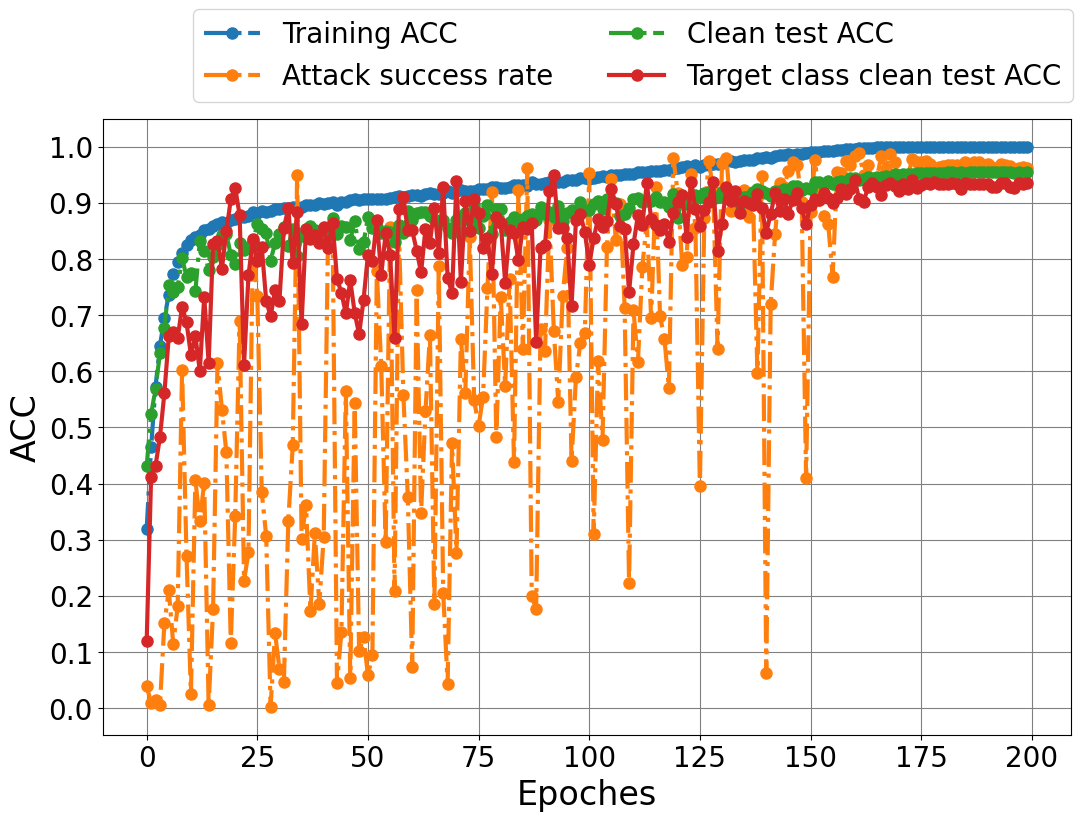

1.0
attack 0.9726666666666667
188
all class clean 0.9552
target clean 0.934


In [31]:
#cell 27
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])